In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV

default_path = '../input/'
sns.set_palette('hls')

In [99]:
train_df = pd.read_csv(default_path+'train.csv')
test_df = pd.read_csv(default_path+'test.csv')

In [100]:
dataset_df = pd.concat([train_df, test_df]).reset_index(drop=True)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## Data Analysis

### 1.Sex

In [ ]:
sns.countplot('Sex',hue='Survived', data=dataset_df)
dataset_df[['Sex', 'Survived']].groupby('Sex').mean()

### 2.Pclass

In [ ]:
print(dataset_df[['Pclass', 'Survived']].groupby('Pclass').mean())
fig, [ax, ax1] = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
sns.countplot(x='Pclass', data=dataset_df, ax=ax)
g = sns.factorplot('Pclass', 'Survived', data=dataset_df, kind='bar', ax=ax1)
plt.close(g.fig)

### 3.Embarked

In [ ]:
print(dataset_df[['Embarked', 'Survived']].groupby('Embarked').mean())
fig, [ax, ax1] = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
sns.countplot('Embarked', data=dataset_df, ax=ax)
g = sns.factorplot('Embarked', 'Survived', data=dataset_df, kind='bar',ax=ax1)
plt.close(g.fig)

### 4.Fare

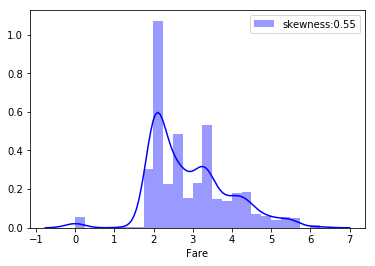

In [163]:
dataset_df['Fare'] = dataset_df['Fare'].fillna(dataset_df['Fare'].median())
sns.distplot(dataset_df['Fare'], color='b', label='skewness:%.2f'%dataset_df['Fare'].skew()).legend(loc='best')

### 5.Parch

In [ ]:
print(dataset_df[['Parch','Survived']].groupby('Parch').mean())
sns.factorplot('Parch', 'Survived',data=dataset_df, kind='bar', palette='hls')

### 6.SibSp

In [ ]:
print(dataset_df[['SibSp','Survived']].groupby('SibSp').mean())
sns.factorplot('SibSp', 'Survived',data=dataset_df, kind='bar', palette='hls')

### 7.Age

In [ ]:
sns.FacetGrid(data=dataset_df, col='Survived').map(sns.distplot, 'Age', color='b')

## Feature Engineering

### 1. Fare

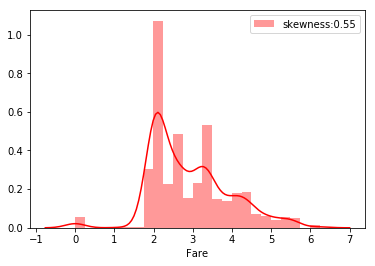

In [101]:
# make log for 'Fare' feature in order to decrease skewness
dataset_df['Fare'] = dataset_df['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
sns.distplot(dataset_df['Fare'], color='r', label='skewness:%.2f'%dataset_df['Fare'].skew()).legend(loc='best')

            Survived
FareBins_4          
0           0.197309
1           0.303571
2           0.441048
3           0.600000
            Survived
FareBins_5          
0           0.217877
1           0.201087
2           0.426901
3           0.443243
4           0.645349
            Survived
FareBins_6          
0           0.205128
1           0.190789
2           0.366906
3           0.436242
4           0.435065
5           0.695035


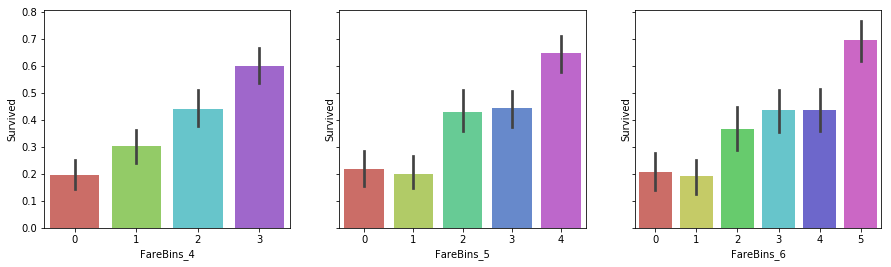

In [102]:
# doing bins_cut for 'Fare' feature
# we dont know which bins_cuts is better, so we do RFE latter(in feature selection part) 

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 4)

for q, ax in zip([4,5,6],[ax1, ax2, ax3]):
    diff_fare_bin_names = 'FareBins_'+str(q)
    fare_bins = pd.qcut(dataset_df['Fare'], q=q, labels=False )
    dataset_df[diff_fare_bin_names] = pd.DataFrame(fare_bins)
    print(dataset_df[[diff_fare_bin_names,'Survived']].groupby(diff_fare_bin_names).mean())
    # factorplot會自行產生一個fig，所以我們要另外關掉
    # https://stackoverflow.com/questions/33925494/seaborn-produces-separate-figures-in-subplots
    g = sns.factorplot(diff_fare_bin_names, 'Survived', data=dataset_df, kind='bar', palette='hls', ax=ax)
    plt.close(g.fig)

### 2.FamilySize

In [103]:
dataset_df['FamilySize'] = dataset_df['Parch'] + dataset_df['SibSp']

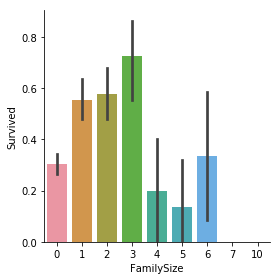

In [120]:
sns.factorplot('FamilySize', 'Survived',data=dataset_df, kind='bar')

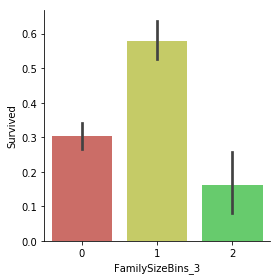

In [106]:
# doing bins_cut for 'FamilySize' feature
# 0 for (-1, 0] ->0
# 1 for (0, 3]  ->1~3
# 2 for (3, 10] ->4~10

# but, unfortunately, this feature seems make overfitting(when I submit and see result on LB)...
# so I wont use this feature to training.. 
bins = [-1, 0, 3, 10]
dataset_df['FamilySizeBins_3'] = pd.cut(dataset_df['FamilySize'], bins=bins, labels=False)
sns.factorplot('FamilySizeBins_3', 'Survived', data=dataset_df, kind='bar')

### 3.Embarked
it seems dont work better for this training... when I removed this feature then LB scores up

I think the reason is this feature relate to 'Fare' feature(e.x. people who from 'S' embarked likely rich than other, so its 'Fare' higher too...)

In [107]:
dataset_df['Embarked'] = dataset_df['Embarked'].fillna('S')

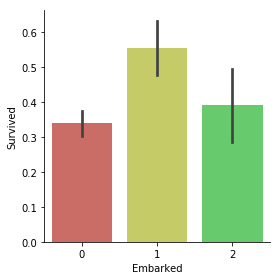

In [108]:
dataset_df['Embarked'] = dataset_df['Embarked'].map({'S':0, 'C':1, 'Q':2})
sns.factorplot('Embarked', 'Survived', data=dataset_df, kind='bar')

### 4.Sex

In [109]:
dataset_df['Sex'] = dataset_df['Sex'].map({'male':0,'female':1})

### 5.Title

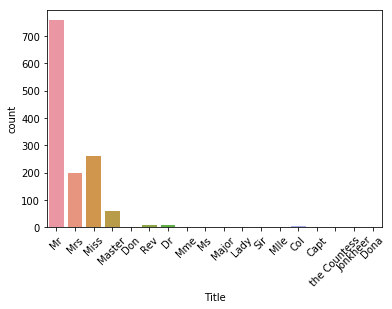

In [111]:
dataset_df['Title'] = pd.DataFrame([i.split(",")[1].split(".")[0].strip() for i in dataset_df['Name']])
g = sns.countplot(dataset_df['Title'])
g = plt.setp(g.get_xticklabels(), rotation=45)

['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


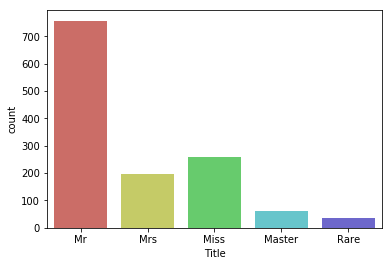

In [112]:
dataset_df['Title'] = dataset_df['Title'].replace(['Don', 'Rev', 'Dr', 'Mme',
                                                   'Ms','Major', 'Lady', 'Sir',
                                                   'Mlle', 'Col', 'Capt', 'the Countess',
                                                   'Jonkheer', 'Dona'],'Rare')
print(dataset_df['Title'].unique())
sns.countplot(dataset_df['Title'])

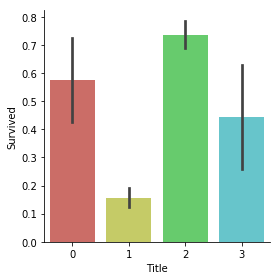

In [113]:
dataset_df['Title'] = dataset_df['Title'].map({'Master': 0, 'Mr':1, 'Miss':2, 'Mrs':2, 'Rare':3})
sns.factorplot('Title', 'Survived', data=dataset_df, kind='bar')

### 6.Age

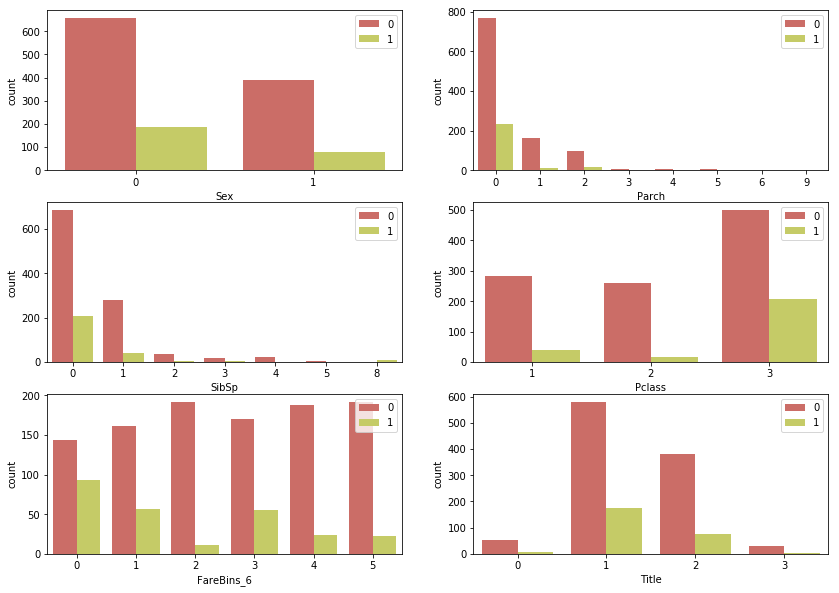

In [114]:
# Observe the fact that missing value of age maybe cause inbalance data distribution
dataset_df['HasAge'] = dataset_df['Age'].isnull().map(lambda i : 1 if i == True else 0)
fig, [ax, ax1, ax2] = plt.subplots(3, 2)
fig.set_size_inches(14, 10)
sns.countplot('Sex', hue='HasAge', data=dataset_df, ax = ax[0]).legend(loc=1)
sns.countplot('Parch', hue='HasAge', data=dataset_df, ax = ax[1]).legend(loc=1)
sns.countplot('SibSp', hue='HasAge', data=dataset_df, ax = ax1[0]).legend(loc=1)
sns.countplot('Pclass', hue='HasAge', data=dataset_df, ax = ax1[1]).legend(loc=1)
sns.countplot('FareBins_6', hue='HasAge', data=dataset_df, ax = ax2[0]).legend(loc=1)
sns.countplot('Title', hue='HasAge', data=dataset_df, ax = ax2[1]).legend(loc=1)

In [115]:
print(dataset_df[['Sex', 'Age']].groupby('Sex').median())
print('-' * 30)
# ahhh...'Master' there is mean little boy
# It seems that use 'Title' median can make better distinguish than 'Sex' feature
print(dataset_df[['Title', 'Age']].groupby('Title').median())

      Age
Sex      
0    28.0
1    27.0
------------------------------
        Age
Title      
0       4.0
1      29.0
2      27.0
3      44.5


In [116]:
# fill missing value with 'Title' median
AgeBins = dataset_df[['Age','Title']].groupby('Title').median().values
dataset_df['NewAge'] = dataset_df['Age'].copy()

NullAge_idx = dataset_df.loc[dataset_df['Age'].isnull()==True]['Title'].index.values
NullAgeBins_idx = dataset_df.loc[dataset_df['Age'].isnull()==True]['Title'].values
dataset_df['NewAge'][NullAge_idx] = AgeBins[NullAgeBins_idx].ravel()
dataset_df['NewAge'] = dataset_df['NewAge'].astype('int')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


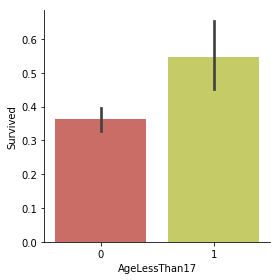

In [117]:
dataset_df['AgeLessThan17'] = (dataset_df['NewAge'] < 17) * 1 #multiply 1 makes boolean change to numbers
sns.factorplot('AgeLessThan17', 'Survived', data=dataset_df, kind='bar')

### 7.Others

In [118]:
dataset_df['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [123]:
deplicate_ticket = []
for tk in dataset_df.Ticket.unique():
    tem = dataset_df.loc[dataset_df.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(dataset_df.loc[dataset_df.Ticket == tk,['Name','Ticket','Fare','Cabin','FamilySize','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(20)

,Name,Ticket,Fare,Cabin,FamilySize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,4.266662,C85,1,1.0
1125,"Cumings, Mr. John Bradley",PC 17599,4.266662,C85,1,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,3.972177,C123,1,1.0
137,"Futrelle, Mr. Jacques Heath",113803,3.972177,C123,1,0.0
6,"McCarthy, Mr. Timothy J",17463,3.948596,E46,0,0.0
1037,"Hilliard, Mr. Herbert Henry",17463,3.948596,E46,0,NaN
7,"Palsson, Master. Gosta Leonard",349909,3.048088,NaN,4,0.0
24,"Palsson, Miss. Torborg Danira",349909,3.048088,NaN,4,0.0
374,"Palsson, Miss. Stina Viola",349909,3.048088,NaN,4,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,3.048088,NaN,4,0.0


In [139]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.FamilySize == 0) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.FamilySize > 0) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.FamilySize == 0]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.FamilySize > 0]))

,Name,Ticket,Fare,Cabin,FamilySize,Survived
6,"McCarthy, Mr. Timothy J",17463,3.948596,E46,0,0.0
20,"Fynney, Mr. Joseph J",239865,3.258097,NaN,0,0.0
791,"Gaskell, Mr. Alfred",239865,3.258097,NaN,0,0.0
195,"Lurette, Miss. Elise",PC 17569,4.987167,B80,0,1.0
681,"Hassab, Mr. Hammad",PC 17572,4.340282,D49,0,1.0
61,"Icard, Miss. Amelie",113572,4.382027,B28,0,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,4.382027,B28,0,1.0


,Name,Ticket,Fare,Cabin,FamilySize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,4.266662,C85,1,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,3.972177,C123,1,1.0
137,"Futrelle, Mr. Jacques Heath",113803,3.972177,C123,1,0.0
7,"Palsson, Master. Gosta Leonard",349909,3.048088,NaN,4,0.0
24,"Palsson, Miss. Torborg Danira",349909,3.048088,NaN,4,0.0
374,"Palsson, Miss. Stina Viola",349909,3.048088,NaN,4,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,3.048088,NaN,4,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [142]:
for _, df_grp in dataset_df.groupby('Ticket'):
    print(_)
    print('*'*10)
    print(df_grp)

110152
**********
      Age Cabin  Embarked      Fare  \
257  30.0   B77         0  4.460144   
504  16.0   B79         0  4.460144   
759  33.0   B77         0  4.460144   

                                                  Name  Parch  PassengerId  \
257                               Cherry, Miss. Gladys      0          258   
504                              Maioni, Miss. Roberta      0          505   
759  Rothes, the Countess. of (Lucy Noel Martha Dye...      0          760   

     Pclass  Sex  SibSp         ...          FareBins_4 FareBins_5  \
257       1    1      0         ...                   3          4   
504       1    1      0         ...                   3          4   
759       1    1      0         ...                   3          4   

     FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  NewAge  \
257           5           0                 0      2       0      30   
504           5           0                 0      2       0      16   
759           5

     Age Cabin  Embarked      Fare                       Name  Parch  \
766  NaN   NaN         1  3.678829  Brewe, Dr. Arthur Jackson      0   

     PassengerId  Pclass  Sex  SibSp         ...          FareBins_4  \
766          767       1    0      0         ...                   3   

    FareBins_5  FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  \
766          3           4           0                 0      3       1   

     NewAge  AgeLessThan17  Connected_Survival  
766      44              0                 0.5  

[1 rows x 22 columns]
112901
**********
       Age Cabin  Embarked     Fare  \
1196  64.0   B26         0  3.27903   

                                                   Name  Parch  PassengerId  \
1196  Crosby, Mrs. Edward Gifford (Catherine Elizabe...      1         1197   

      Pclass  Sex  SibSp         ...          FareBins_4 FareBins_5  \
1196       1    1      1         ...                   2          3   

      FareBins_6  FamilySize  FamilySiz

113804
**********
      Age Cabin  Embarked      Fare                         Name  Parch  \
607  27.0   NaN         0  3.417727  Daniel, Mr. Robert Williams      0   

     PassengerId  Pclass  Sex  SibSp         ...          FareBins_4  \
607          608       1    0      0         ...                   2   

    FareBins_5  FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  \
607          3           4           0                 0      1       0   

     NewAge  AgeLessThan17  Connected_Survival  
607      27              0                 0.5  

[1 rows x 22 columns]
113806
**********
      Age Cabin  Embarked      Fare  \
724  27.0    E8         0  3.972177   
809  33.0    E8         0  3.972177   

                                               Name  Parch  PassengerId  \
724                   Chambers, Mr. Norman Campbell      0          725   
809  Chambers, Mrs. Norman Campbell (Bertha Griggs)      0          810   

     Pclass  Sex  SibSp         ...          FareBin

**********
      Age Cabin  Embarked      Fare                  Name  Parch  PassengerId  \
288  42.0   NaN         0  2.564949  Hosono, Mr. Masabumi      0          289   

     Pclass  Sex  SibSp         ...          FareBins_4 FareBins_5  \
288       2    0      0         ...                   1          2   

     FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  NewAge  \
288           2           0                 0      1       0      42   

     AgeLessThan17  Connected_Survival  
288              0                 0.5  

[1 rows x 22 columns]
239059
**********
       Age Cabin  Embarked      Fare                       Name  Parch  \
1076  40.0   NaN         0  2.772589  Maybery, Mr. Frank Hubert      0   

      PassengerId  Pclass  Sex  SibSp         ...          FareBins_4  \
1076         1077       2    0      0         ...                   2   

     FareBins_5  FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  \
1076          2           3           0      

[1 rows x 22 columns]
348125
**********
       Age Cabin  Embarked      Fare                         Name  Parch  \
1236  16.0   NaN         0  2.034706  Abelseth, Miss. Karen Marie      0   

      PassengerId  Pclass  Sex  SibSp         ...          FareBins_4  \
1236         1237       3    1      0         ...                   0   

     FareBins_5  FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  \
1236          0           0           0                 0      2       0   

      NewAge  AgeLessThan17  Connected_Survival  
1236      16              1                 0.5  

[1 rows x 22 columns]
349201
**********
     Age Cabin  Embarked      Fare                Name  Parch  PassengerId  \
738  NaN   NaN         0  2.066331  Ivanoff, Mr. Kanio      0          739   

     Pclass  Sex  SibSp         ...          FareBins_4 FareBins_5  \
738       3    0      0         ...                   0          1   

     FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  NewAge

392095
**********
       Age Cabin  Embarked      Fare                     Name  Parch  \
1014  28.0   NaN         0  1.981001  Carver, Mr. Alfred John      0   

      PassengerId  Pclass  Sex  SibSp         ...          FareBins_4  \
1014         1015       3    0      0         ...                   0   

     FareBins_5  FareBins_6  FamilySize  FamilySizeBins_3  Title  HasAge  \
1014          0           0           0                 0      1       0   

      NewAge  AgeLessThan17  Connected_Survival  
1014      28              0                 0.5  

[1 rows x 22 columns]
392096
**********
      Age Cabin  Embarked      Fare                 Name  Parch  PassengerId  \
751   6.0  E121         0  2.523727  Moor, Master. Meier      1          752   
823  27.0  E121         0  2.523727   Moor, Mrs. (Beila)      1          824   

     Pclass  Sex  SibSp         ...          FareBins_4 FareBins_5  \
751       3    0      0         ...                   1          2   
823       3    

In [152]:
# the same ticket family or friends
dataset_df['Connected_Survival'] = 0.5 # default 
for _, df_grp in dataset_df.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows(): #相同tickets的逐列枚舉
            smax = df_grp.drop(ind)['Survived'].max() #扣掉自己找剩下列的最大值
            smin = df_grp.drop(ind)['Survived'].min() #扣掉自己找剩下列的最小值
            passID = row['PassengerId']
            if (smax == 1.0 and smin == 1.0): #如果最大和最小都是1，代表全部都活著
                dataset_df.loc[dataset_df['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smax == 0.0 and smin==0.0): #如果最大和最小都是0，代表全部都死亡
                dataset_df.loc[dataset_df['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(dataset_df[dataset_df['Connected_Survival']!=0.5].shape[0]))
dataset_df.groupby('Connected_Survival')[['Survived']].mean().round(3)

1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 0.0
----------
1.0 0.0
----------
0.0 0.0
----------
0.0 0.0
----------
nan nan
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----------
nan nan
----------
0.0 0.0
----------
nan nan
----------
nan nan
----------
nan nan
----------
0.0 0.0
----------
nan nan
----------
0.0 0.0
----------
0.0 0.0
----------
0.0 0.0
----------
0.0 0.0
----------
1.0 1.0
----------
1.0 1.0
----------
nan nan
----------
0.0 0.0
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----------
nan nan
----------
0.0 0.0
----------
0.0 0.0
----------
1.0 1.0
----------
1.0 0.0
----------
1.0 0.0
----------
1.0 0.0
----------
1.0 0.0
----------
1.0 0.0
----------
1.0 0.0
----------
1.0 1.0
----------
0.0 0.0
----------
nan nan
----------
0.0 0.0
----------
1.0 1.0
----------
0.0 0.0
----------
0.0 0.0
----------
1.0 1.0
----------
1.0 1.0
----------
1.0 1.0
----

,Survived
Connected_Survival,
0.0,0.225
0.5,0.339
1.0,0.709


## Data Preprocess

In [153]:
dataset_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,FareBins_4,FareBins_5,FareBins_6,FamilySize,FamilySizeBins_3,Title,HasAge,NewAge,AgeLessThan17,Connected_Survival
0,22.0,NaN,0,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,...,0,0,0,1,1,1,0,22,0,0.5
1,38.0,C85,1,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,...,3,4,5,1,1,2,0,38,0,0.5
2,26.0,NaN,0,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,...,1,1,1,0,0,2,0,26,0,0.5
3,35.0,C123,0,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,...,3,4,4,1,1,2,0,35,0,0.0
4,35.0,NaN,0,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,...,1,1,1,0,0,1,0,35,0,0.5


## Feature Selection

In [ ]:
dataset_df.columns

In [129]:
# results tell us choose n fatures for best cv scores
# and then we can choose feature depends on ranking_

# and it's seems like FareBins_6 will cause overfiting(result of LB decrease)
temp_df_for_feature_selection = ['Connected_Survival','AgeLessThan17', 'Embarked', 'Pclass', 'Parch', 'SibSp', 'Sex', 'FamilySize', 'FareBins_4', 'FareBins_5', 'FareBins_6']
X_train_for_feature_selection = (dataset_df[:len(train_df)])[temp_df_for_feature_selection]
y_train_for_feature_selection = train_df['Survived']
RFC = RandomForestClassifier(n_estimators=250, n_jobs=4)
RFEselector = RFECV(estimator=RFC, cv=10, n_jobs=4)
RFEselector.fit(X_train_for_feature_selection, y_train_for_feature_selection)
print(RFEselector.ranking_)
print(RFEselector.n_features_)
print(RFEselector.grid_scores_ * 100)

# free memory
del temp_df_for_feature_selection, X_train_for_feature_selection, y_train_for_feature_selection, RFC, RFEselector

[1 1 1 1 1 1 1 1 1 1 1]
11
[78.66981614 80.69112473 80.47514471 81.03824764 81.26424356 80.59261151
 79.36287028 79.4752582  81.1531892  81.93973442 81.94347974]


## Training

In [161]:
data = dataset_df[['Title', 'Connected_Survival', 'AgeLessThan17', 'Sex',
                   'Pclass', 'FareBins_5', 'Survived']]
train_data = data[:len(train_df)]
test_data = data[len(train_df):]
test_data = test_data.drop(['Survived'],axis=1)

X_train = train_data.values[:, :-1]
y_train = train_data.values[:, -1:].ravel()
X_test = test_data.values

In [162]:
kfold = StratifiedKFold(n_splits=10)
RFC = RandomForestClassifier(random_state=2, n_estimators=250, oob_score=True, n_jobs=4).fit(X_train, y_train)
print(RFC.oob_score_)

cv = cross_val_score(RFC, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=4, verbose=1)
print(cv.mean(), cv.std())

0.8473625140291807
0.8462263080240608 0.033380197922084624


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.9s finished


In [156]:
prediction = RFC.predict(X_test)
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': prediction.astype(int)})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
